WARNING  
Only for deployment - do not alter this file, check the main one. 

Performance  
Due to speed of execution and limited resource allocation this file has had most of the lines commented out. Check the main file for the notebook, this is just used for code execution at deployment level.

home_path -> That´s the only thing needs to be setup on this file.


## Imports

In [1]:
import pandas  as pd
import numpy   as np
import seaborn as sns
import umap.umap_ as umap
import pickle

from matplotlib import pyplot as plt

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from IPython.display import HTML
from IPython.core.display import Image

# from pandas_profiling import ProfileReport

from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import preprocessing as pp
from plotly import express as px
from sklearn import decomposition as dd
from sklearn import ensemble as en
from sklearn import mixture as mx
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn import ensemble as en

from scipy.cluster import hierarchy as hc

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

home_path = '~/insider-clients-clustering/'
# home_path = '../'


## Helper functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [24,9]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container { width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## Load dataset

In [3]:
df_raw = pd.read_csv(home_path + 'data/raw/data.csv', encoding = "ISO-8859-1")  # when exporting to linux machine, generates encoding error, not utf-8

In [4]:
df_raw.shape

(541909, 9)

In [5]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


In [6]:
df_raw.drop('Unnamed: 8',axis = 1, inplace = True)
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# Data Preparation

In [7]:
df1 = df_raw.copy()

## Columns Rename

In [8]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [9]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price','customer_id', 'country']

df1.columns = cols_new

## Data Dimensions

In [10]:
print(f'Number of Rows:{df1.shape[0]}')
print(f'Number of Columns:{df1.shape[1]}')

Number of Rows:541909
Number of Columns:8


## Data types

In [11]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object


## Check NA

In [12]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

**135.080 customers id.... 'missing'**

## Filling NAs

Split dataset into missing vs not_missing:

In [13]:
df_missing = df1.loc[df1['customer_id'].isna(),:]
df_not_missing = df1.loc[~df1['customer_id'].isna(),:]
df_missing.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
622,536414,22139,NaN,56,29-Nov-16,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,29-Nov-16,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,29-Nov-16,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,29-Nov-16,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,29-Nov-16,1.66,NaN,United Kingdom


In [14]:
df_not_missing.shape

(406829, 8)

Dataset has 135.080 records where customer ID not present:

In [15]:
df_missing.shape

(135080, 8)

In [16]:
# missing_invoice = df_missing['invoice_no'].drop_duplicates().tolist()
# missing_invoice[0:10]

In [17]:
# df_not_missing.loc[df_not_missing['invoice_no'].isin(missing_invoice), :].head()

- All customer_id from 19000 onwards will be a missing id just for training, and we will merge it on df1:

In [18]:
# Decision:
# each NAN customer ID will be a new single customer time purchase, just for training(?)

# Create Reference:
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup),1) # linspace or arrange

# merging original w/ reference df:
df1 = pd.merge(df1, df_backup, on = 'invoice_no', how = 'left')

# need to keep columns...
# Coalesce:
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop aux columns
df1 = df1.drop(columns=['customer_id_x','customer_id_y'])
print(df1.isna().sum())
df1.head()



invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [19]:
# Removing NAs
df1 = df1.dropna(subset =['description','customer_id'])
print('Removed data: {:.5f} %, thats a total of {} rows.'.format(1 - (df1.shape[0] / df_raw.shape[0]), (df_raw.shape[0] - df1.shape[0] )))

Removed data: 0.00268 %, thats a total of 1454 rows.


In [20]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64

## Change dtypes

In [21]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [22]:
df1['customer_id'] = df1['customer_id'].astype(int)

In [23]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y' )
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [24]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int32
dtype: object

## Descriptive Statistics

In [25]:
# doing the model first, then come back - 'clustering not an end'.

Splitting dataset into numerical/categorical:

In [26]:
num_attributes = df1.select_dtypes(include =['int64','float64', 'int32'])
cat_attributes = df1.select_dtypes(exclude =['int64','float64', 'int32'])

### Numerical Attributes

In [27]:
# central tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
# Dispersion - std dev, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

merged = pd.concat([ct1,ct2,d1,d2,d3,d4,d5,d6])
merged['index'] = ['Mean','Median', 'Std', 'Min','Max','Range','Skew','Kurtosis']
merged.set_index('index', inplace = True)
merged.T


index,Mean,Median,Std,Min,Max,Range,Skew,Kurtosis
quantity,9.603129,3.00,218.007397,-80995.00,80995.0,161990.00,-0.281253,120252.449063
unit_price,4.623519,2.08,96.889538,-11062.06,38970.0,50032.06,186.257919,58848.017575
customer_id,16678.153600,16241.00,2907.570262,12346.00,22709.0,10363.00,0.493600,-0.792496


1. Min for quantity is negative - returns?.
2. Unity Price 0.0 ? free item?


### Categorical Attributes

In [28]:
#number of invoices with letters:
number_invs_letters = len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search( '[^0-9]+', x))), 'invoice_no'].drop_duplicates())
print(f'Invoices with letters: {number_invs_letters}')

#number of stock codes with letters:
number_stk_letters = len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search( '[^0-9]+', x))), 'stock_code'].drop_duplicates())
print(f'Stock Codes with letters: {number_stk_letters}')

only_letters_unique_stock_code = cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x ) ) ), 'stock_code' ].unique()
print(f'Unique stock codes with only letters: {only_letters_unique_stock_code}')

Invoices with letters: 3839
Stock Codes with letters: 1073
Unique stock codes with only letters: ['POST' 'D' 'DOT' 'M' 'S' 'AMAZONFEE' 'm' 'DCGSSBOY' 'DCGSSGIRL' 'PADS'
 'B' 'CRUK']


In [29]:
cat_attributes.sample(1)

,invoice_no,stock_code,description,invoice_date,country
385831,570217,84559A,3D SHEET OF DOG STICKERS,2017-10-07,United Kingdom


In [30]:
# some further investigation...
# df1.loc[df1['description'] == 'RED RETROSPOT PEG BAG'].sort_values('customer_id').reset_index()

# df1.loc[df1['invoice_no'] == 'C548995']

In [31]:
df1.sample(1)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
534446,581147,23265,SET OF 3 WOODEN TREE DECORATIONS,1,2017-12-05,1.25,United Kingdom,16426


#### Invoice No

- Invoice number has letter numbers, and are mostly negative quantities.

In [32]:
# There are invoices with letters
df_invoices_w_letters = df1.loc[df1['invoice_no'].apply(lambda x: bool (re.search('[^0-9]+', x))),:]

print('Total number of invoices w/ letters')
print(len(df_invoices_w_letters))

# Are all invoices that start with letters 'negative quantity' one?
print('Total number of invoices w/ letters with negative quantity')
print(len(df_invoices_w_letters[df_invoices_w_letters['quantity'] <0]))

# Yes, all invoices starting with letters are negative quantity except three / 'Adjust bad debt'.
print(df_invoices_w_letters[df_invoices_w_letters['quantity'] >= 0].head())
print(f"\nTotal # of non negative invoices: {df_invoices_w_letters[df_invoices_w_letters['quantity'] >= 0].invoice_no.count()} ")

Total number of invoices w/ letters
9291
Total number of invoices w/ letters with negative quantity
9288
       invoice_no stock_code      description  quantity invoice_date  unit_price         country  customer_id
299982    A563185          B  Adjust bad debt         1   2017-08-10    11062.06  United Kingdom        21497
299983    A563186          B  Adjust bad debt         1   2017-08-10   -11062.06  United Kingdom        21498
299984    A563187          B  Adjust bad debt         1   2017-08-10   -11062.06  United Kingdom        21499

Total # of non negative invoices: 3 


#### Stock Code

In [33]:
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))),'stock_code'].unique()   

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

**To do:**  
Remove Stock_codes in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']  
New stock_Codes after joining missing data ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm',   'DCGSSBOY',        'DCGSSGIRL', 'PADS', 'B', 'CRUK']
 

#### Description

In [34]:
# Todo - delete description

#### Country

In [35]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

- UK main market:

In [36]:
df1['country'].value_counts(normalize = True).head(6)

United Kingdom    0.914089
Germany           0.017569
France            0.015833
EIRE              0.015165
Spain             0.004687
Netherlands       0.004387
Name: country, dtype: float64

In [37]:
# df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending = False).head()

# Data Filtering

In [38]:
df2 = df1.copy()

Makes sense to filter some data: negative quantity values, assuming returns in the table.

2 ways - 
- exclude what has been returned, like customer had never bought the product?
- other way to create new feature based on returns. - Return feature would be beneficial to score clients?
(returns consumes resources)

Creating feature for returns.

In [39]:
df2.loc[df2['unit_price'] > 0.0, ['customer_id', 'description', 'unit_price']].sort_values('unit_price', ascending = True).head(10)
# df1[['customer_id', 'description', 'unit_price']].sort_values('unit_price', ascending = True).head(10))


,customer_id,description,unit_price
157195,13952,PADS TO MATCH ALL CUSHIONS,0.001
279045,15618,PADS TO MATCH ALL CUSHIONS,0.001
361741,13405,Bank Charges,0.001
359871,16198,PADS TO MATCH ALL CUSHIONS,0.001
108088,16422,Discount,0.010
182729,12901,Discount,0.030
355050,16422,Manual,0.030
4287,15838,ROTATING SILVER ANGELS T-LIGHT HLDR,0.030
362028,16629,POPART WOODEN PENCILS ASST,0.040
303023,16488,POPART WOODEN PENCILS ASST,0.040


In [40]:
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


- Filetering out: 
    - products with unit_price less than 4p(?), 
    - letters on stock_code, non-specific countries, 
    - and dropping 
    
- Auxiliary dataframes df2_returns and df2_purchase.

In [41]:
# Numerical Attributes
# unit price > 0
df2 = df2.loc[df2['unit_price'] >= 0.04, :]  # there are products that price is 0.001

# Categorical Attributes
# stock code != [POST, D, M, DOT, CRUK]  
# New ones ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']
#df2 = df2[~df2['stock_code'].isin(['POST' 'D' 'M' 'PADS' 'DOT' 'CRUK'])]  # removing these products...
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]  # removing these products...

# Countries
# remove not specific like EU, and unspecified.
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# Description - drop it
df2 = df2.drop(columns = 'description', axis = 1)

# quantity - assuming negative numbers are returns.
df2_returns = df2.loc[df2['quantity'] < 0,:]
df2_purchase = df2.loc[df2['quantity'] > 0,:]


# df2.loc[df2['quantity'] < 0,:].sort_values(['customer_id','description']).head()

# Feature Engineering

In [42]:
df3 = df2.copy()
df3_purchase = df2_purchase.copy()
df3_returns = df2_returns.copy()

## Feature Creation

Here df3_ref will be the table compiled with features grouped by customers ID.

In [43]:
# data referencing
df3_ref = df3.drop(['invoice_no','stock_code',
                   'quantity','invoice_date','unit_price',
                   'country'], axis = 1).drop_duplicates(ignore_index = True)
df3_ref.head()

# Gross Revenue ( qtt * price)
# Recency - latest purchase data for customer
# Frequency - how many products client bought in one year period

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


### Gross Revenue

Calculating the total ammount of revenue a customer has generated

In [44]:
# Gross Revenue:
df3_purchase.loc[:,'gross_revenue'] = df3_purchase.loc[:,'quantity'] * df2_purchase.loc[:,'unit_price']

# # Monetary:
df_monetary = df3_purchase.loc[:,['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df3_ref = pd.merge(df3_ref, df_monetary, how = 'left', on = 'customer_id')
df3_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

### Recency - Days since last purchase

In [45]:
# Recency - how long has it been since the last puchase.
df3_recency = df3_purchase[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df3_recency['recency_days'] = (df3_purchase['invoice_date'].max() - df3_recency['invoice_date']).dt.days  # using dt, to get int type
df3_recency = df3_recency[['customer_id','recency_days']].copy()

print('*******Nas before merge:')
print(df3_recency.isna().sum())

df3_ref = pd.merge(df3_ref, df3_recency, how = 'left', on = 'customer_id')

print('*******Nas After merge:')
print(df3_ref.isna().sum())
# 33 clients never bought anything, onlyu returns... likely data doesn´t comprehend these purchases.

*******Nas before merge:
customer_id     0
recency_days    0
dtype: int64
*******Nas After merge:
customer_id       0
gross_revenue    91
recency_days     91
dtype: int64


### Ammount purchased

In [46]:
# This it just the number different (variety of) products bought
df3_ammt_purchased = df3_purchase[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns ={'invoice_no':'invoice_ammt'})
df3_ref = pd.merge(df3_ref, df3_ammt_purchased, how = 'left', on = 'customer_id')
df3_ref.isna().sum()
df3_ref.head()

,customer_id,gross_revenue,recency_days,invoice_ammt
0,17850,5391.21,372.0,34.0
1,13047,3232.59,56.0,9.0
2,12583,6705.38,2.0,15.0
3,13748,948.25,95.0,5.0
4,15100,876.00,333.0,3.0


### Ammount products items  purchased

In [47]:
# This it just the number of products bought
df3_i_ammt_purchased = df3_purchase[['customer_id', 'quantity']].groupby('customer_id').sum().rename(columns = {'quantity':'item_ammt'}).reset_index()
df3_ref = pd.merge(df3_ref, df3_i_ammt_purchased, how = 'left', on = 'customer_id')
df3_ref.isna().sum()
df3_ref.head()

,customer_id,gross_revenue,recency_days,invoice_ammt,item_ammt
0,17850,5391.21,372.0,34.0,1733.0
1,13047,3232.59,56.0,9.0,1390.0
2,12583,6705.38,2.0,15.0,5028.0
3,13748,948.25,95.0,5.0,439.0
4,15100,876.00,333.0,3.0,80.0


### Ammount different products purchased

In [48]:
# This it just the number of products bought
df3_ammt_type_of_prod_purchased = df3_purchase[['customer_id', 'stock_code']].groupby('customer_id').count().rename(columns = {'stock_code':'n_of_dif_products'}).reset_index()
df3_ref = pd.merge(df3_ref, df3_ammt_type_of_prod_purchased, how = 'left', on = 'customer_id')
print(df3_ref.isna().sum())
df3_ref.head()

customer_id           0
gross_revenue        91
recency_days         91
invoice_ammt         91
item_ammt            91
n_of_dif_products    91
dtype: int64


,customer_id,gross_revenue,recency_days,invoice_ammt,item_ammt,n_of_dif_products
0,17850,5391.21,372.0,34.0,1733.0,297.0
1,13047,3232.59,56.0,9.0,1390.0,171.0
2,12583,6705.38,2.0,15.0,5028.0,232.0
3,13748,948.25,95.0,5.0,439.0,28.0
4,15100,876.00,333.0,3.0,80.0,3.0


### Average Ticket Value

In [49]:
# Avg Ticket
df3_avg_ticket = df3_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df3_avg_ticket['avg_ticket'] = np.round(df3_avg_ticket['avg_ticket'],2 )
df3_ref = pd.merge(df3_ref, df3_avg_ticket, on = 'customer_id', how = 'left')
df3_ref.isna().sum()

# df_ref.head()

customer_id           0
gross_revenue        91
recency_days         91
invoice_ammt         91
item_ammt            91
n_of_dif_products    91
avg_ticket           91
dtype: int64

### Average Recency Days

In [50]:
# df2.loc[df2['customer_id'] == 17850,:]

df3_aux = df3[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id','invoice_date'])
df3_aux['next_customer_id'] = df3_aux['customer_id'].shift() #next cx
df3_aux['previous_date'] = df3_aux['invoice_date'].shift() # next  invoice dt

df3_aux['avg_recency_days'] = df3_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis = 1)

df3_aux = df3_aux.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis =1).dropna()

#avg recency
df3_avg_recency_days = df3_aux.groupby('customer_id').mean().reset_index()

#Merging
df3_ref = pd.merge(df3_ref, df3_avg_recency_days, on ='customer_id', how = 'left' )

df3_ref.isna().sum()
# df_aux.dtypes


customer_id             0
gross_revenue          91
recency_days           91
invoice_ammt           91
item_ammt              91
n_of_dif_products      91
avg_ticket             91
avg_recency_days     2816
dtype: int64

### Frequency

In [51]:
### Frequency purchase

df3_max = df3[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').max()
df3_min = df3[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').min()
# df2_purchase = df2[['customer_id','invoice_date']].drop_duplicates().groupby('customer_id').count()
df3_purchase.head()

df3_aux = ( df2[['customer_id','invoice_no','invoice_date']].drop_duplicates()
                                                           .groupby('customer_id')
                                                           .agg( max_  = ('invoice_date','max'),
                                                                 min_  = ('invoice_date','min'),
                                                                 days_ = ('invoice_date',lambda x: ((x.max() - x.min() ).days) +1  ),
                                                                 buy_  = ('invoice_no', 'count' ) ) ).reset_index()

# frequency  # how many times a customer has bought given the specific period (number of days b/w
# 1st purchase and last purchase) eg 30 days, has bought 2 times = 2 / 30  = 1/15 = 0.066 ) 
# then... 'customer buys 0.06 a day' -maybe it should be # of times has bought last 12mo, and 
# if 1st purchase less than that, then use tome kind of formula to compensate for new customers


df3_aux['frequency'] = df3_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis = 1 )

# Merging
df3_ref = pd.merge(df3_ref, df3_aux[['customer_id', 'frequency']], on = 'customer_id', how = 'left')
# df_ref.head()
df3_ref.isna().sum()

# df_aux.sort_values('frequency', ascending = False).head(20)
# df_aux[df_aux['customer_id'] == 17850].head()

customer_id             0
gross_revenue          91
recency_days           91
invoice_ammt           91
item_ammt              91
n_of_dif_products      91
avg_ticket             91
avg_recency_days     2816
frequency               0
dtype: int64

In [52]:
df3_ref.head()

,customer_id,gross_revenue,recency_days,invoice_ammt,item_ammt,n_of_dif_products,avg_ticket,avg_recency_days,frequency
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.15,35.500000,0.486111
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.90,27.250000,0.048780
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.90,23.187500,0.045699
3,13748,948.25,95.0,5.0,439.0,28.0,33.87,92.666667,0.017921
4,15100,876.00,333.0,3.0,80.0,3.0,292.00,8.600000,0.136364


### Number of Returns

In [53]:
df3_returns = df3_returns[['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtt_returns'})
df3_returns['qtt_returns'] = df3_returns['qtt_returns'] * -1

df3_ref = pd.merge(df3_ref, df3_returns, how = 'left', on ='customer_id')
df3_ref.loc[df3_ref['qtt_returns'].isna(), 'qtt_returns'] = 0
df3_ref.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
invoice_ammt           91
item_ammt              91
n_of_dif_products      91
avg_ticket             91
avg_recency_days     2816
frequency               0
qtt_returns             0
dtype: int64

### Basket Size - Number of product items per basket  *sum

In [54]:
# invoice (basket) > products > number of total items for all products
# df2_purchase.head()

In [55]:
# The total Quantity of products items divided by the number of times a customer has transactioned. 

df3_aux =(df3_purchase.loc[:,['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                      .agg(n_purchase = ('invoice_no', 'nunique'), 
                                                                           n_products = ('quantity','sum'))
                                                                      .reset_index() )


df3_aux['avg_basket_size'] = df3_aux['n_products'] / df3_aux['n_purchase']

df3_ref = pd.merge(df3_ref, df3_aux[['customer_id','avg_basket_size']], how = 'left', on = 'customer_id')
df3_ref.isna().sum()
# missing NA´s the ones in 'returns'

customer_id             0
gross_revenue          91
recency_days           91
invoice_ammt           91
item_ammt              91
n_of_dif_products      91
avg_ticket             91
avg_recency_days     2816
frequency               0
qtt_returns             0
avg_basket_size        91
dtype: int64

### Basket, distinctive items per purchase. *count

In [56]:
# Transaction > product > item ammount
# The total number of different products divided by the number of times a customer transactioned.

df3_aux = (df3_purchase.loc[:,['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                       .agg(n_purchase = ('invoice_no', 'nunique'), 
                                                                            n_products = ('quantity','nunique'))
                                                                       .reset_index() )

df3_aux['avg_unique_basket_size'] = df3_aux['n_products'] / df3_aux['n_purchase']

df3_ref = pd.merge(df3_ref, df3_aux[['customer_id','avg_unique_basket_size']], how = 'left', on = 'customer_id')
df3_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
invoice_ammt                91
item_ammt                   91
n_of_dif_products           91
avg_ticket                  91
avg_recency_days          2816
frequency                    0
qtt_returns                  0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

Check if returns will remain in df_ref:

In [57]:
df3_ref.head()

,customer_id,gross_revenue,recency_days,invoice_ammt,item_ammt,n_of_dif_products,avg_ticket,avg_recency_days,frequency,qtt_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.15,35.500000,0.486111,40.0,50.970588,0.176471
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.90,27.250000,0.048780,35.0,154.444444,1.222222
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.90,23.187500,0.045699,50.0,335.200000,1.600000
3,13748,948.25,95.0,5.0,439.0,28.0,33.87,92.666667,0.017921,0.0,87.800000,1.600000
4,15100,876.00,333.0,3.0,80.0,3.0,292.00,8.600000,0.136364,22.0,26.666667,0.666667


In [58]:
df3_ref.shape

(5787, 12)

# EDA

In [59]:
df4 = df3_ref.dropna().copy()
# df4_debug = df3_ref.dropna().copy()  #delme
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
invoice_ammt              0
item_ammt                 0
n_of_dif_products         0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtt_returns               0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## Univariate Analysis

In [60]:
# profile = ProfileReport(df4)
# profile.to_file('output.html')

### Gross Revenue

In [61]:
# sns.boxplot(df4.gross_revenue)

## Bivariate Analysis

**Low variance on Frequency and Avg. Ticket**

In [62]:
# sns.pairplot(df4.drop(columns = 'customer_id'));

## Spatial Study

In [63]:
# full_feat:
df43_full_features = df4.drop(columns = ['customer_id'], axis = 1).copy()

# embedded space:
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'n_of_dif_products', 'frequency', 'qtt_returns']
df43_less_features = df4[cols_selected].copy()
df43_less_features.drop(columns= 'customer_id', inplace = True)
# min-max, standard scales, robust scaler?

### Modeling with 2 sets 'full features', 'less features'

In [64]:
# Many features were not useful, so trying modeling with 2 different sets


mm = pp.MinMaxScaler()

df43_full_features['gross_revenue'] = mm.fit_transform(df43_full_features[['gross_revenue']])  #*
# pickle.dump(mm, open(home_path + 'features/gross_revenue_scaler.pkl', 'wb'))

# 'customer_id', 
df43_full_features['recency_days']          = mm.fit_transform( df43_full_features[['recency_days']])  # *
# pickle.dump(mm, open(home_path + 'features/full_feat_recendy_days_scaler.pkl', 'wb'))
df43_full_features['invoice_ammt']          = mm.fit_transform( df43_full_features[['invoice_ammt']])
# pickle.dump(mm, open(home_path + 'features/full_feat_invoice_ammt_scaler.pkl', 'wb'))
df43_full_features['item_ammt']             = mm.fit_transform( df43_full_features[['item_ammt']])  # *
# pickle.dump(mm, open(home_path + 'features/full_feat_item_ammt_scaler.pkl', 'wb'))
df43_full_features['n_of_dif_products']     = mm.fit_transform( df43_full_features[['n_of_dif_products']])
# pickle.dump(mm, open(home_path + 'features/full_feat_n_of_dif_products_scaler.pkl', 'wb'))
df43_full_features['avg_ticket']            = mm.fit_transform( df43_full_features[['avg_ticket']])
# pickle.dump(mm, open(home_path + 'features/full_feat_avg_ticket_scaler.pkl', 'wb'))
df43_full_features['avg_recency_days']      = mm.fit_transform( df43_full_features[['avg_recency_days']])
# pickle.dump(mm, open(home_path + 'features/full_feat_avg_recency_days_scaler.pkl', 'wb'))
df43_full_features['frequency']             = mm.fit_transform( df43_full_features[['frequency']])  #*
# pickle.dump(mm, open(home_path + 'features/full_feat_frequency_scaler.pkl', 'wb'))
df43_full_features['qtt_returns']           = mm.fit_transform( df43_full_features[['qtt_returns']])  #*
# pickle.dump(mm, open(home_path + 'features/full_feat_qtt_returns_scaler.pkl', 'wb'))
df43_full_features['avg_basket_size']       = mm.fit_transform( df43_full_features[['avg_basket_size']])
# pickle.dump(mm, open(home_path + 'features/full_feat_avg_basket_size_scaler.pkl', 'wb'))
df43_full_features['avg_unique_basket_size']= mm.fit_transform( df43_full_features[['avg_unique_basket_size']])
# pickle.dump(mm, open(home_path + '/features/full_feat_avg_unique_basket_size_scaler.pkl', 'wb'))


df43_less_features['gross_revenue'] = mm.fit_transform(df43_less_features[['gross_revenue']])
# pickle.dump(mm, open(home_path + 'features/less_feat_gross_revenue_scaler.pkl', 'wb'))

df43_less_features['recency_days']          = mm.fit_transform( df43_less_features[['recency_days']])
# pickle.dump(mm, open(home_path + 'features/less_feat_full_feat_recendy_days_scaler.pkl', 'wb'))

df43_less_features['n_of_dif_products']     = mm.fit_transform( df43_less_features[['n_of_dif_products']])
# pickle.dump(mm, open(home_path + 'features/less_feat_full_feat_n_of_dif_products_scaler.pkl', 'wb'))

df43_less_features['frequency']             = mm.fit_transform( df43_less_features[['frequency']])
# pickle.dump(mm, open(home_path + 'features/less_feat_frequency_scaler.pkl', 'wb'))

df43_less_features['qtt_returns']           = mm.fit_transform( df43_less_features[['qtt_returns']])
# pickle.dump(mm, open(home_path + 'features/less_feat_qtt_returns_scaler.pkl', 'wb'))


df43_less_features.columns

Index(['gross_revenue', 'recency_days', 'n_of_dif_products', 'frequency',
       'qtt_returns'],
      dtype='object')

In [65]:
X_less_features = df43_less_features.copy()
X_full_features = df43_full_features.copy()

In [66]:
df43_full_features.head()

,gross_revenue,recency_days,invoice_ammt,item_ammt,n_of_dif_products,avg_ticket,avg_recency_days,frequency,qtt_returns,avg_basket_size,avg_unique_basket_size
0,0.019292,0.997319,0.160976,0.008799,0.037770,0.000285,0.094521,0.160512,0.000494,0.001234,0.000000
1,0.011559,0.150134,0.039024,0.007056,0.021692,0.000298,0.071918,0.014470,0.000432,0.003789,0.066088
2,0.024000,0.005362,0.068293,0.025538,0.029476,0.000476,0.060788,0.013441,0.000617,0.008252,0.089963
3,0.003375,0.254692,0.019512,0.002225,0.003445,0.000565,0.251142,0.004165,0.000000,0.002143,0.089963
4,0.003116,0.892761,0.009756,0.000401,0.000255,0.005162,0.020822,0.043717,0.000272,0.000634,0.030979


In [67]:
df43_less_features.head()

,gross_revenue,recency_days,n_of_dif_products,frequency,qtt_returns
0,0.019292,0.997319,0.037770,0.160512,0.000494
1,0.011559,0.150134,0.021692,0.014470,0.000432
2,0.024000,0.005362,0.029476,0.013441,0.000617
3,0.003375,0.254692,0.003445,0.004165,0.000000
4,0.003116,0.892761,0.000255,0.043717,0.000272


### PCA - full features

In [68]:
X_full_features.head()

,gross_revenue,recency_days,invoice_ammt,item_ammt,n_of_dif_products,avg_ticket,avg_recency_days,frequency,qtt_returns,avg_basket_size,avg_unique_basket_size
0,0.019292,0.997319,0.160976,0.008799,0.037770,0.000285,0.094521,0.160512,0.000494,0.001234,0.000000
1,0.011559,0.150134,0.039024,0.007056,0.021692,0.000298,0.071918,0.014470,0.000432,0.003789,0.066088
2,0.024000,0.005362,0.068293,0.025538,0.029476,0.000476,0.060788,0.013441,0.000617,0.008252,0.089963
3,0.003375,0.254692,0.019512,0.002225,0.003445,0.000565,0.251142,0.004165,0.000000,0.002143,0.089963
4,0.003116,0.892761,0.009756,0.000401,0.000255,0.005162,0.020822,0.043717,0.000272,0.000634,0.030979


In [69]:

# pca = dd.PCA( n_components = X_full_features.shape[1])
# principal_component = pca.fit_transform(X_full_features)

# # plot explaining variables
# features = range ( pca.n_components_)
# plt.bar(features, pca.explained_variance_ratio_, color = 'black')

# # PCA COMPONENTS
# df_pca = pd.DataFrame(principal_component)

In [70]:
# df_pca.head()

In [71]:
# sns.scatterplot(x = 0, y = 1, data = df_pca)
# plt.title('PCA - full features[0 and 1]', fontsize = 18);

#### PCA - Less Features

In [72]:
# X_less_features.head()

In [73]:
# pca = dd.PCA( n_components = X_less_features.shape[1])
# principal_components = pca.fit_transform(X_less_features)

# # plot explaining variables
# features = range ( pca.n_components_)
# plt.bar(features, pca.explained_variance_ratio_, color = 'black')

# # PCA COMPONENTS
# df_pca = pd.DataFrame(principal_components)

In [74]:
# sns.scatterplot( x=0, y=1, data=df_pca )

- Both PCAs show no clear spacing

### UMAP - full features

In [75]:
# # UMAP

# # reducer = umap.UMAP(n_neighbors = 9, random_state = 42)
# reducer = umap.UMAP(random_state = 42)
# embedding = reducer.fit_transform(X_full_features)

# # embedding
# df_pca['embedding_x'] = embedding[:,0]
# df_pca['embedding_y'] = embedding[:,1]

# #plotting umap
# sns.scatterplot( x = 'embedding_x', y = 'embedding_y', data = df_pca )
# plt.title('UMAP - full features', fontsize = 18);

#### UMAP - Less features

In [76]:
# # UMAP

# # reducer = umap.UMAP(n_neighbors = 9, random_state = 42)
# reducer = umap.UMAP(random_state = 42)
# embedding = reducer.fit_transform(X_less_features)

# # embedding
# df_pca['embedding_x'] = embedding[:,0]
# df_pca['embedding_y'] = embedding[:,1]

# #plotting umap
# sns.scatterplot( x = 'embedding_x', y = 'embedding_y', data = df_pca )

### t-SNE

#### t-SNE - full features

In [77]:
# # UMAP
# import umap.umap_ as umap
# from sklearn.manifold import TSNE
# # reducer = umap.UMAP(n_neighbors = 9, random_state = 42)
# reducer = TSNE(n_components = 2, random_state = 42, n_jobs = -1)
# embedding = reducer.fit_transform(X_full_features)

# # embedding
# df_pca['embedding_x'] = embedding[:,0]
# df_pca['embedding_y'] = embedding[:,1]

# #plotting umap
# sns.scatterplot( x = 'embedding_x', y = 'embedding_y', data = df_pca )
# plt.title('t-SNE full features', fontsize = 18);

#### t-SNE - less features

In [78]:
# # UMAP
# import umap.umap_ as umap
# from sklearn.manifold import TSNE
# # reducer = umap.UMAP(n_neighbors = 9, random_state = 42)
# reducer = TSNE(n_components = 2, random_state = 42, n_jobs = -1)
# embedding = reducer.fit_transform(X_less_features)

# # embedding
# df_pca['embedding_x'] = embedding[:,0]
# df_pca['embedding_y'] = embedding[:,1]

# #plotting umap
# sns.scatterplot( x = 'embedding_x', y = 'embedding_y', data = df_pca )

### Tree-Based Embedding - v1.0

In [79]:
# df4.head()
# X = df4.drop( columns = ['customer_id', 'gross_revenue'], axis = 1 )  # df4 - no transformation applied!!
# y = df4['gross_revenue'] # using gross_revenue

X_rf_full = X_full_features.drop(columns = ['gross_revenue'])
y_rf_full = X_full_features['gross_revenue']

# model definition
rf_model_full = en.RandomForestRegressor( random_state = 42, n_estimators = 100)

# model training
rf_model_full.fit( X_rf_full, y_rf_full)

#leaf
# rf_model.apply( X )  # applying own training data

#dataframe Leag

RandomForestRegressor(random_state=42)

In [80]:
df_leaf_full = pd.DataFrame(rf_model_full.apply(X_rf_full))
df_leaf_full.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,2999,2726,3318,3340,3015,3058,3229,3126,2823,3141,3168,3072,3151,3186,3115,2722,3130,2799,3083,3237,3281,2670,2861,3292,2830,3118,3026,3223,3084,3180,2904,3285,3367,3372,2970,2991,3026,3138,2741,2938,3035,3182,3422,3133,3172,3038,2858,3345,3400,3005,2795,3207,3114,3088,3042,2998,3150,3042,3118,3129,3015,3180,3333,3243,2877,3052,3070,3311,3133,3246,3079,3003,2691,2977,2830,3168,3353,2718,3214,2798,3134,3321,2762,3095,3000,3014,3008,3374,3136,2973,3255,2937,3188,2773,3211,3132,2950,3324,3045,3319
1,2936,3093,3018,2945,3026,3037,2939,2809,2785,3034,3119,3052,3086,3078,2793,2768,2574,2757,2810,2417,3258,2702,2814,2828,3145,3118,2925,2788,3048,3103,2981,3016,2970,2961,2836,2959,2617,2343,2716,2913,2962,2788,2954,3114,3120,2938,3013,2880,3011,2919,2774,3110,3080,2979,3005,2960,2725,2781,3060,3138,2990,2826,2907,3207,2855,2503,2998,2923,2842,2961,2964,2984,2733,2879,2825,2508,2866,2702,3176,2772,3028,2899,2749,2785,2889,3140,2940,2980,3098,2839,2510,2921,2941,2758,3137,3053,2930,2894,2925,2802
2,3490,3618,3578,3405,3593,3619,3529,3545,3708,3615,3574,3590,3530,3630,3518,3555,3553,3648,3608,3477,3480,3652,3610,3519,3599,3595,3491,3643,3524,3705,3450,3687,3649,3619,3587,3636,3534,3530,3595,3480,3657,3399,3655,3616,3489,3590,3599,3673,3648,3610,3575,3496,3624,3615,3669,3663,3611,3649,3541,3405,3602,3614,3589,3683,3389,3629,3614,3640,3618,3610,3586,3429,3588,3513,3611,3557,3585,3543,3564,3600,3521,3454,3546,3541,3604,3623,3603,3690,3542,3393,3586,3465,3563,3504,3611,3562,3576,3614,3591,3660
3,2151,1961,1570,1400,1828,1501,2107,1786,2075,2114,2232,1498,1316,1598,1593,1824,1868,1570,1337,1264,1822,1244,1489,1574,2174,1979,1582,1945,1433,1508,1816,1558,1367,1578,1392,1739,1555,1423,1358,1795,1778,1436,1369,1744,1616,1487,1569,1381,2055,1230,1583,1563,1341,2196,2085,2020,1590,1727,1470,2120,1574,2121,1748,1806,1515,1508,2093,2050,1555,2084,2318,1612,1993,2207,1663,1545,1349,1544,1967,1943,2116,1441,1737,1553,1420,1840,1521,2159,1354,1328,1801,1378,2025,2081,2052,2168,1525,998,1840,2098
4,216,270,298,593,175,469,725,688,175,165,599,160,689,950,703,716,199,209,586,696,515,707,467,212,645,195,562,536,136,760,703,867,197,338,220,619,433,197,539,590,738,717,450,607,728,544,934,661,699,619,610,965,740,564,563,571,726,208,727,587,229,244,558,188,664,437,570,733,701,604,579,190,603,616,702,344,708,585,602,183,200,333,565,332,587,215,288,852,354,807,421,209,685,576,694,740,592,901,697,207


In [81]:
# # Reducing dimensionality  # reduce the projection of the total columns columns into 2.
# reducer = umap.UMAP(random_state = 42)
# embedding = reducer.fit_transform(df_leaf_full)

# #embedding
# df_tree_full = pd.DataFrame()
# df_tree_full['embedding_x'] = embedding[:,0]
# df_tree_full['embedding_y'] = embedding[:,1]

# #plotting
# sns.scatterplot(x = 'embedding_x',
#                y = 'embedding_y',
#                data = df_tree_full)


#### Tree-Based Embedding - v2.0

In [82]:

# X_less = X_less_features.drop(columns =['gross_revenue'], axis = 1)
# y_less = X_less_features['gross_revenue']

# # model definition
# rf_model_less = en.RandomForestRegressor( random_state = 42, n_estimators = 100)

# # model training
# rf_model_less.fit( X_less, y_less)

# pickle.dump(rf_model_less, open(home_path + 'models/rf_model_2.0.pkl', 'wb'))

# #leaf
# # rf_model.apply( X )  # applying own training data

# #dataframe Leag

# df_leaf_less = pd.DataFrame(rf_model_less.apply(X_less))
# df_leaf_less.head()

In [83]:
# # Reducing dimensionality  # reduce the projection of the 100 columns into 2.
# reducer = umap.UMAP(random_state = 42)
# embedding = reducer.fit_transform(df_leaf_less)

# #embedding
# df_tree_v2 = pd.DataFrame()
# df_tree_v2['embedding_x'] = embedding[:,0]
# df_tree_v2['embedding_y'] = embedding[:,1]

# #plotting
# sns.scatterplot(x = 'embedding_x',
#                y = 'embedding_y',
#                data = df_tree_v2)

#### Tree based embedded - simple - in use

In [84]:
X = df4.drop( columns = ['customer_id', 'gross_revenue'], axis = 1 )  # df4 - no transformation applied!!
y = df4['gross_revenue'] # using gross_revenue

# model definition
rf_model = en.RandomForestRegressor( random_state = 42, n_estimators = 100)

# model training
rf_model.fit( X, y)



df_leaf = pd.DataFrame(rf_model. apply(X))
df_leaf.head()



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,2998,2726,3318,3335,3016,3058,3229,3133,2821,3140,3168,3072,3154,3189,3116,2722,3130,2799,3043,3255,3280,2669,2862,3293,2831,3125,3026,3231,3084,3181,2904,3284,3365,3374,2970,2992,3024,3135,2741,2950,3035,3183,3421,3134,3175,3038,3035,3335,3400,3006,2796,3211,3114,3089,3042,2999,3151,3042,3118,3132,3015,3180,3333,3243,2876,3055,3068,3312,3133,3246,3079,3284,2692,2977,2832,3168,3306,2718,3214,2796,3135,3322,2762,3094,2999,3015,3005,3376,3135,2973,3258,2939,3233,2773,3214,3130,2950,3368,3045,3326
1,2936,3093,3022,2944,3024,3036,2938,2809,2785,3035,3114,3052,3085,3077,2792,2768,2572,2757,2811,2418,3260,2702,2813,2824,3146,3117,2925,2797,3048,3104,2982,3014,2970,2961,2840,2959,2613,2344,2713,2913,2966,2792,2953,3115,3122,2939,3011,2877,3012,2932,2774,3110,3077,2978,3004,2956,2722,2790,3059,3140,2990,2826,2907,3204,2854,2503,2999,2924,2853,2960,2964,2984,2732,2880,2828,2508,2863,2701,3179,2765,3024,2896,2752,2785,2903,3141,2939,2983,3098,2839,2510,2921,2941,2758,3137,3051,2931,2893,2921,2802
2,3490,3616,3578,3400,3594,3618,3529,3546,3687,3614,3576,3590,3535,3629,3517,3552,3555,3648,3601,3477,3482,3652,3610,3518,3599,3597,3489,3630,3512,3705,3451,3682,3653,3627,3580,3635,3532,3531,3593,3478,3657,3399,3654,3618,3492,3590,3580,3676,3645,3605,3576,3495,3621,3619,3666,3664,3611,3649,3543,3408,3603,3618,3590,3683,3389,3630,3614,3641,3592,3611,3584,3428,3588,3512,3613,3554,3584,3541,3570,3601,3521,3452,3547,3538,3603,3621,3611,3690,3546,3394,3588,3465,3564,3505,3615,3570,3574,3616,3586,3659
3,2151,1962,1571,1399,1828,1500,2107,1785,2073,2115,2231,1498,1310,1600,1593,1824,1869,1570,1337,1265,1828,1248,1488,1574,2173,1981,1582,1946,1460,1509,1816,1558,1363,1579,1397,1736,1554,1423,1352,1796,1778,1436,1369,1744,1616,1492,1569,1381,2054,1230,1582,1564,1342,2197,2085,2022,1590,1726,1466,2122,1574,2122,1749,1810,1514,1510,2096,2049,1470,2086,2318,1612,2000,2207,1664,1545,1351,1543,1967,1946,2118,1442,1731,1553,1420,1840,1521,2161,1352,1325,1799,1378,2052,2081,2051,2168,1529,1001,1840,2100
4,217,270,298,592,175,466,725,687,175,165,598,160,688,953,707,712,199,208,586,696,518,703,467,213,646,195,563,535,139,760,702,866,197,337,220,618,434,197,539,589,740,717,451,607,726,547,936,661,703,619,609,965,740,562,563,572,725,208,724,586,229,244,557,188,663,437,568,740,700,600,580,190,603,610,704,345,709,586,599,183,197,332,565,332,587,216,287,852,353,806,414,208,687,576,692,743,575,907,697,207


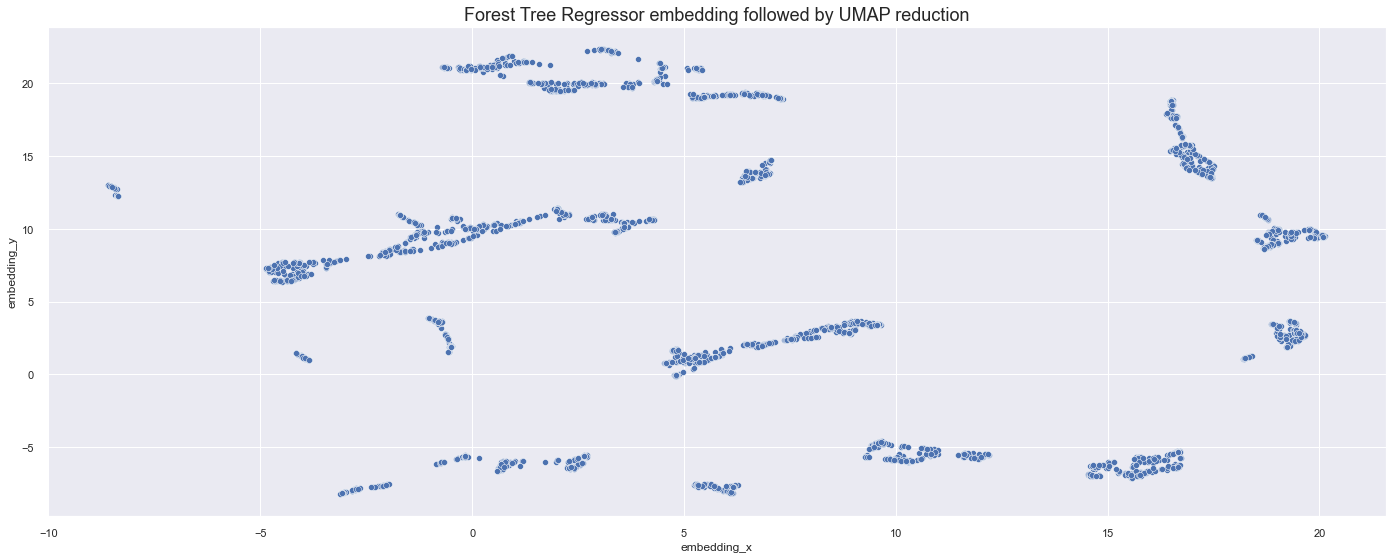

In [85]:
# Reducing dimensionality  # reduce the projection of the total columns columns into 2.
reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(df_leaf)

#embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:,0]
df_tree['embedding_y'] = embedding[:,1]

#plotting
sns.scatterplot(x = 'embedding_x',
               y = 'embedding_y',
               data = df_tree)
plt.title('Forest Tree Regressor embedding followed by UMAP reduction', fontsize = 18);

# Data Preparation


In [86]:
# # df5 = df4.copy()
# df5_aux = df4.copy()
df5_df_tree = df_tree.copy()
# # df5_df_tree_v2 = df_tree_v2.copy()

In [87]:

# sns.distplot(df5_aux['gross_revenue']);
# # Talvez um minmax, tá muito deseguilibrada essa disribuicao.


In [88]:
# sns.distplot(np.log(df5_aux['gross_revenue']))

In [89]:
# Previously tested transformations before deciding going with embedded spaces:


# # mm = pp.MinMaxScaler()
# # ss = pp.StandardScaler()
# # rs = pp.RobustScaler()

# df5_aux['gross_revenue'] = mm.fit_transform(df5_aux[['gross_revenue']])
# df5_aux['recency_days'] = mm.fit_transform(df5_aux[['recency_days']])
# df5_aux['invoice_ammt'] = mm.fit_transform(df5_aux[['invoice_ammt']])
# df5_aux['item_ammt'] = mm.fit_transform(df5_aux[['item_ammt']])
# df5_aux['n_of_dif_products'] = mm.fit_transform(df5_aux[['n_of_dif_products']])

# # df5_aux['avg_ticket'] = mm.fit_transform(df5_aux[['avg_ticket']])
# # df5_aux['avg_recency_days'] = mm.fit_transform(df5_aux[['avg_recency_days']])

# df5_aux['frequency'] = mm.fit_transform(df5_aux[['frequency']])
# df5_aux['qtt_returns'] = mm.fit_transform(df5_aux[['qtt_returns']])

# # df5_aux['avg_basket_size'] = mm.fit_transform(df5_aux[['avg_basket_size']])
# # df5_aux['avg_unique_basket_size'] = mm.fit_transform(df5_aux[['avg_unique_basket_size']])  

# # avg wont make sense in the end, not looking for avg of the avg in the end.

# variable = 'gross_revenue'

# # ['customer_id', 'gross_revenue', 'recency_days', 'n_of_dif_products', 'frequency', 'qtt_returns']

# Data as it is
# print('Min:{} - Max:{}'.format(df5_aux[variable].min(), df5_aux[variable].max() ) )
# sns.displot(df5_aux[variable]);

# # Data Standardized/Rescaled
# print('Min:{} - Max:{}'.format(df5_aux[variable].min(), df5_aux[variable].max() ) )
# sns.displot(df5_aux[variable]);

In [90]:
# Box Plot
# sns.boxplot(df5_aux[variable]);

# Feature Selection

In [91]:
# Previous cycles:
# cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'n_of_dif_products', 'frequency', 'qtt_returns']

In [92]:
# df6 = df5[cols_selected].copy()
df6_df_tree = df5_df_tree.copy()
# df6_df_tree_v2 = df5_df_tree_v2.copy()

# df6_df_tree.head()


# Hyperparameter Fine-Tuning

In [93]:
# X = df6.drop(columns = ['customer_id'])
X = df6_df_tree.copy()
# X_v2 = df6_df_tree_v2.copy()

In [94]:
# X.head()

In [95]:
# clusters = [2, 3, 4, 5, 6, 7 , 8 ,9 ]
cluster_hyperpam_testing = np.arange(2,25,1)

## K-Means

In [96]:

kmeans_list = []
for k in cluster_hyperpam_testing:
    # defining model
    kmeans_model = c.KMeans(n_clusters = k)

    # defining training
    kmeans_model.fit(X)

    # define prediction
    labels_71_kmeans_v1 = kmeans_model.predict(X)
    # performance
    # Using silhouette inside metrics package.
    kmeans_list.append( m.silhouette_score(X, labels_71_kmeans_v1, metric = 'euclidean') )
    

#### v2.0 

# kmeans_list_v2 = []
# for k in cluster_hyperpam_testing:
#     # defining model
#     kmeans_model_v2 = c.KMeans(n_clusters = k)

#     # defining training
#     kmeans_model_v2.fit(X_v2)

#     # define prediction
#     labels_71_kmeans_v2 = kmeans_model_v2.predict(X_v2)
#     # performance
#     # Using silhouette inside metrics package.
#     kmeans_list_v2.append( m.silhouette_score(X_v2, labels_71_kmeans_v2, metric = 'euclidean') )

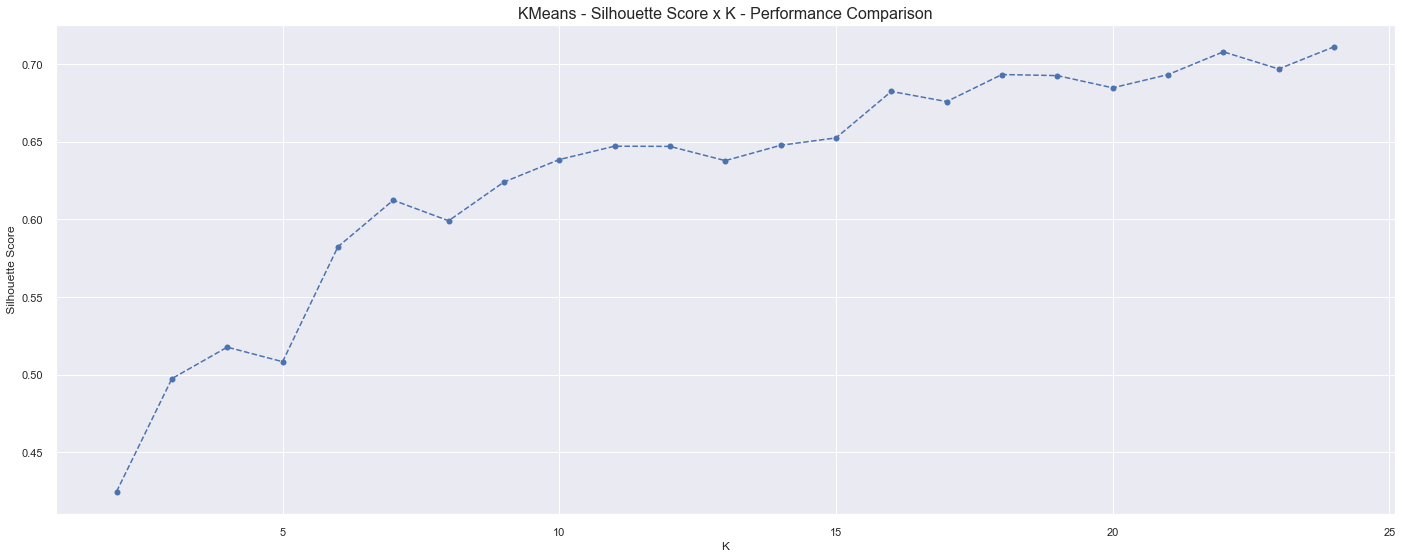

In [97]:
plt.plot(cluster_hyperpam_testing, kmeans_list, linestyle='--', marker = 'o', color ='b')
# plt.plot(cluster_hyperpam_testing, kmeans_list_v2, linestyle='--', marker = 'o', color ='green')
plt.xlabel('K')
plt.ylabel(' Silhouette Score ')
plt.title('KMeans - Silhouette Score x K - Performance Comparison', fontsize = 16)



blue_patch = mpatches.Patch(color='blue', label='Raw data - simple')
# green_patch = mpatches.Patch(color='green', label='MinMax Transformation')
# yellow_patch = mpatches.Patch(color='yellow', label='MinMax Transformation')

# plt.legend(handles=[blue_patch, green_patch]);



## GMM

In [98]:
# # def, training, predict, score
# gmm_list =[]
# for k in cluster_hyperpam_testing:
#     gmm_model = mx.GaussianMixture(n_components = k)

#     gmm_model.fit(X)

#     labels_72_GMM = gmm_model.predict(X)

#     sil_gmm_v1 = m.silhouette_score(X, labels_72_GMM, metric = 'euclidean')
#     gmm_list.append(sil_gmm_v1)

    
# ### v2.0
# gmm_list_v2 =[]
# for k in cluster_hyperpam_testing:
#     gmm_model_v2 = mx.GaussianMixture(n_components = k)

#     gmm_model_v2.fit(X_v2)

#     labels_72_GMM_v2 = gmm_model_v2.predict(X_v2)

#     sil_gmm_v2 = m.silhouette_score(X_v2, labels_72_GMM_v2, metric = 'euclidean')
#     gmm_list_v2.append(sil_gmm_v2)
    

In [99]:
# plt.plot(cluster_hyperpam_testing, gmm_list, linestyle='--', marker = 'o', color = 'b')
# plt.plot(cluster_hyperpam_testing, gmm_list_v2, linestyle='--', marker = 'o', color = 'green')
# plt.xlabel('K')
# plt.ylabel('Silhouette Score')
# plt.title('GMM Silhouette Score K');

## Hierarchical Clustering

In [100]:
# # model definition and training
# hc_model = hc.linkage(X, 'ward')
# hc_model_v2 = hc.linkage(X_v2, 'ward')



In [101]:
# DENDROGRAM

# hc.dendrogram(
#     hc_model,
#     leaf_rotation = 90,
#     leaf_font_size = 8)
# plt.plot()

In [102]:
# hc.dendrogram(
#     hc_model,
#     truncate_mode='lastp',
#     p=12,
#     leaf_rotation = 90,
#     leaf_font_size = 8,
#     show_contracted = True)
# plt.title('Dendogram simplified', fontsize = 18)
# plt.show()


### H-Clustering Silhouette Score

In [103]:
# hc_list = []
# for k in cluster_hyperpam_testing:
#     # def, training, predict score
#     hc_model = hc.linkage(X, 'ward')

#     # prediction
#     labels_hc_v1 = hc.fcluster(hc_model, k, criterion = 'maxclust')

#     #metrics
#     sil_hc_v1 = m.silhouette_score(X, labels_hc_v1, metric = 'euclidean')
#     hc_list.append( sil_hc_v1 )

    
# #### v2.0
# hc_list_v2 = []
# for k in cluster_hyperpam_testing:
#     # def, training, predict score
#     hc_model_v2 = hc.linkage(X_v2, 'ward')

#     # prediction
#     labels_hc_v2 = hc.fcluster(hc_model_v2, k, criterion = 'maxclust')

#     #metrics
#     sil_hc_v2 = m.silhouette_score(X_v2, labels_hc_v2, metric = 'euclidean')
#     hc_list_v2.append( sil_hc_v2 )

In [104]:
# plt.plot(cluster_hyperpam_testing, hc_list, linestyle = '--', marker ='o', color = 'b')
# plt.plot(cluster_hyperpam_testing, hc_list_v2, linestyle = '--', marker ='o', color = 'green')
# plt.xlabel('k')
# plt.ylabel('')

# blue_patch731 = mpatches.Patch(color='b', label='v1 - more features')
# green_patch731 = mpatches.Patch(color='green', label='v2 - lesser features')

# plt.legend(handles=[blue_patch731, green_patch731])
# plt.title('K performance and Silhouette Score', fontsize = 18)

### H-Clustering Silhoutte plots

- Even though Hierarchical Clustering points out optimum k at a higher value, that becomes impractical in terms of RFM modeling, so checking performance between 8 and 14 groups.

In [105]:
# h7_clusters_interest = [8,9,10,11,12,13,14]
# # h7_clusters_interest = [8] #,9,10,11,12,13,14]

In [106]:
# fig, ax = plt.subplots(4,2)
# fig.set_size_inches(25,20)  #setting a size for fig

# print ('HC starting counting clusters at 1, not 0.')
# for k in h7_clusters_interest:
#     q,mod = divmod(k  - h7_clusters_interest[0],2)
#     ax[q, mod].set_xlim([ -0.1, 1])
#     ax[q, mod].set_ylim([ 0, len(X) + (k+1)*10])
#     #model def
#     hc_model = hc.linkage(X, 'ward')

#     # predict
#     labels = hc.fcluster(hc_model, k, criterion = 'maxclust')
    
#     # print(f'Labels given by current model {np.unique(labels)}')
#     # performance
#     ss = m.silhouette_score(X, labels, metric = 'euclidean')
#     silhouette_avg = ss
#     print('When k {}, Silhouette Score: {}'.format(k, ss))
#     samples_silhouette_values = m.silhouette_samples(X, labels)
#     y_lower = 10
    
    
#     for i in range(1, k +1):
#         # select clusters
#         ith_samples_silhouette_values = samples_silhouette_values[labels == i]

#         #sorting
#         ith_samples_silhouette_values.sort()
        
#         # size_cluster
#         size_cluster_i = ith_samples_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i
        
#         cmap = cm.get_cmap('Spectral')
#         color = cmap(i/k)
#         # fill_betweenx  (matplotlib)
#         ax[q,mod].fill_betweenx( 
#             np.arange(y_lower, y_upper), 0, 
#             ith_samples_silhouette_values,
#             )
        
        
#         ax[q, mod].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
#         y_lower = y_upper + 10


#     ax[q, mod].set_ylim([0, len(X) + (k + 1) * 10])
#     ax[q, mod].set_title(f'k {k}')
#     ax[q, mod].set_xlabel(f'Silhouette score')
#     ax[q, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
#     ax[q, mod].set_yticks([])
#     ax[q, mod].set_ylabel('Clusters')

#     ax[q, mod].axvline(x=silhouette_avg, color="red", linestyle="--")
    
# # https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

## DBSCAN

In [107]:
# eps = 1.2
# min_samples = 33
# dbscan_model = c.DBSCAN( eps = eps, min_samples = min_samples) 

# labels_db_scan = dbscan_model.fit_predict(X)

# db_scan_sil = m.silhouette_score( X, labels_db_scan, metric = 'euclidean')

# print('Silhouette Score {} '.format(db_scan_sil))
# print('Clusters k includes noisy one (-1) if present: {}'.format(len(unique(labels_db_scan) )))
# print('labels {} '.format(unique(labels_db_scan)))
# db_scan_k_v1 = len(unique(labels_db_scan)) - 1 # we will need that variable in the results

# print('\n\nVersion2:')
# dbscan_model_v2 = c.DBSCAN( eps = eps, min_samples = min_samples) 

# labels_db_scan_v2 = dbscan_model_v2.fit_predict(X_v2)

# db_scan_sil_v2 = m.silhouette_score( X_v2, labels_db_scan, metric = 'euclidean')

# print('Silhouette Score {} '.format(db_scan_sil_v2))
# print('Clusters k includes noisy one (-1) if present: {}'.format(len(unique(labels_db_scan_v2) )))
# print('labels {} '.format(unique(labels_db_scan_v2)))



### Neighbors issue - tuning

In [108]:
# # checking on v1
# neighbors = NearestNeighbors(n_neighbors = min_samples).fit(X)
# distances, indices = neighbors.kneighbors(X)

In [109]:
# distances = np.sort(distances, axis = 0)
# distances = distances[:,1]
# plt.plot(distances)

In [110]:
# # zooming in
# plt.plot(distances[2900:])

## RESULTS

In [111]:
# db_scan_sil

In [112]:
# db_scan_k

In [113]:
# df_results = pd.DataFrame(
#     {'KMeans':kmeans_list, 'GMM': gmm_list,
#      'HCList':hc_list}).T

# dbscan_list = []
# for a in (df_results.columns):
#     if a != db_scan_k_v1:
#         dbscan_list.append(0.0)
#     else:
#         dbscan_list.append(db_scan_sil)

# print(dbscan_list)
    
# df_results = pd.DataFrame(
#     {'KMeans':kmeans_list, 'GMM': gmm_list,
#      'KMeans_v2':kmeans_list_v2, 'GMM_v2': gmm_list_v2,
#      'HCList_v2':hc_list_v2,'HCList':hc_list, 'DBScan':dbscan_list}).T

# df_results.columns = cluster_hyperpam_testing
# # df_results = df_results.iloc[:,7:]
# df_results.style.highlight_max(color = 'lightgreen', axis = 1)

- General optimum for k here would be range from 14 to 24. However for business team that would represent a lot of groups to be working with.

## Within-Cluster Sum of Square (WSS)

In [114]:
# # trying out diffente cluster values

# # clusters = [2, 3, 4, 5, 6, 7 ]
# h77_clusters = np.arange(2,14,1)

In [115]:
# wss = []
# for k in h77_clusters:
#     # model definition
#     kmeans = c.KMeans( init = 'random', n_clusters = k, n_init = 10, max_iter = 300, random_state = 42)  # doing centroids at random # n_init, centroid starting times(?)
#     # model training
#     kmeans.fit(X)
#     # validation
#     wss.append(kmeans.inertia_)

# # plootting wss - ELBOW method # We want to findout the best k before going for the final model
# # like a pre-training model.
# # This graph is supposed to look like an elbow... (?)
# # Supposed to choose the point in the graph where the changes(The angle) most significative happen in this case
# # happens where K = 3 and 5 - it is up to the Data Scientist to choose the best point.b

# plt.plot(h77_clusters, wss, linestyle = '--', marker ='o', color='b')
# plt.xlabel('K')
# plt.ylabel('Within-Cluster Sum of Square');
# plt.title('WSS vs K')

In [116]:
# # Searching for K, using the library yellowbrick
# from yellowbrick.cluster import KElbowVisualizer
# # !pip install yellowbrick.cluster

# kmeans = KElbowVisualizer(c.KMeans(), k=h77_clusters, timing = False)
# kmeans.fit(X)
# kmeans.show()  # getting best value k 

# # knee method....

## Sillhouette Score

In [117]:
# kmeans_si = KElbowVisualizer(c.KMeans(), k=h77_clusters, metric = 'silhouette', timings = False)
# kmeans_si.fit(X)
# kmeans_si.show()

## Silhouette Analysis - KMeans

In [155]:
# h79_clusters = [8,9,10,11,12,13]

# fig, ax = plt.subplots(3,2, figsize = (25,18))
# pos = 1
# posi = 1
# for k in h79_clusters:
#     km = c.KMeans(n_clusters = k, init = 'random', n_init = 10, max_iter = 100, random_state = 42)
#     q, mod = divmod(k, 2)

#     visualizer = SilhouetteVisualizer(km, colors = 'yellowbrick', ax=ax[posi - 1][mod])
    
#     if pos % 2 == 0:
#         posi += 1
#     pos += 1
    
#     visualizer.fit(X)
#     visualizer.finalize()

Silhouette now giving us much insight on the number of clusters. A lot more organized after opting for the embedded tree space.

# Model Training

## K-Means

In [119]:
# model definition
# Opting for 11 - it is not the optimum division, however 
# in terms of business and RFM goal, makes sense to go with a lower number,
# silhouette score not the optimum, ok given the kind of problem.

k = 11
kmeans = c.KMeans(init = 'random', n_clusters = k, n_init = 10, max_iter = 300, random_state = 42)

# model training
kmeans.fit(X)

# clustering
# labels = kmeans.predict(X)
labels = kmeans.labels_


## Cluster Validation

In [120]:
# from sklearn import metrics as m

In [121]:
# WSS (Whithin Cluster Sum of Squares)
print( f'WSS Value: {kmeans.inertia_}')

# SS ( Silhouette Score)
print(f'SS Value: {m.silhouette_score(X, labels, metric = "euclidean")}')

WSS Value: 17223.318359375
SS Value: 0.6153544187545776


# Cluster Analysis

- At this moment we are not applying the better model(hc) for this separation - todo: next review cycle.

## Visual Inspection

In [122]:
# df9 = df6.copy()
df9 = X.copy()
df9['cluster'] = labels
df9.head()

,embedding_x,embedding_y,cluster
0,18.189165,1.047733,5
1,14.702026,-6.494765,6
2,16.770378,16.416286,7
3,-0.536808,1.909567,10
4,4.409677,21.412285,8


Text(0.5, 1.0, 'Visual Cluster Representation - k = 11, Forest Tree Regressor followed by UMAP > KMeans ')

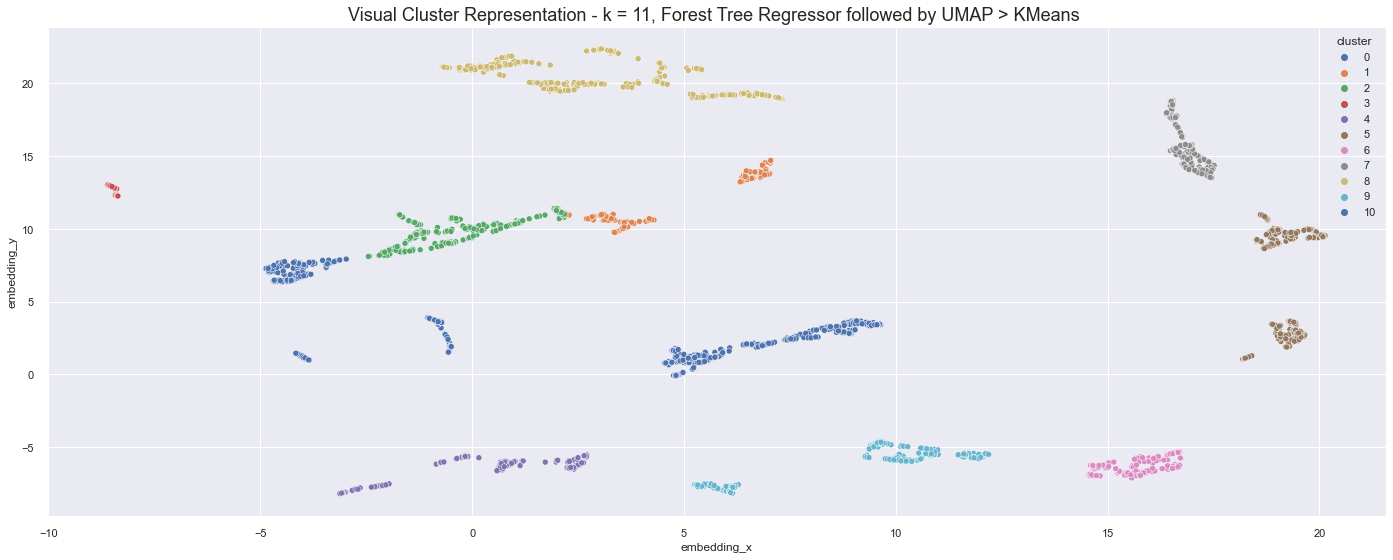

In [123]:
sns.scatterplot( x = 'embedding_x', y = 'embedding_y', data = df9, hue = 'cluster', palette = 'deep')
plt.title('Visual Cluster Representation - k = 11, Forest Tree Regressor followed by UMAP > KMeans ', fontsize = 18)

### Multi-Feature

C:\Users\Fu\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


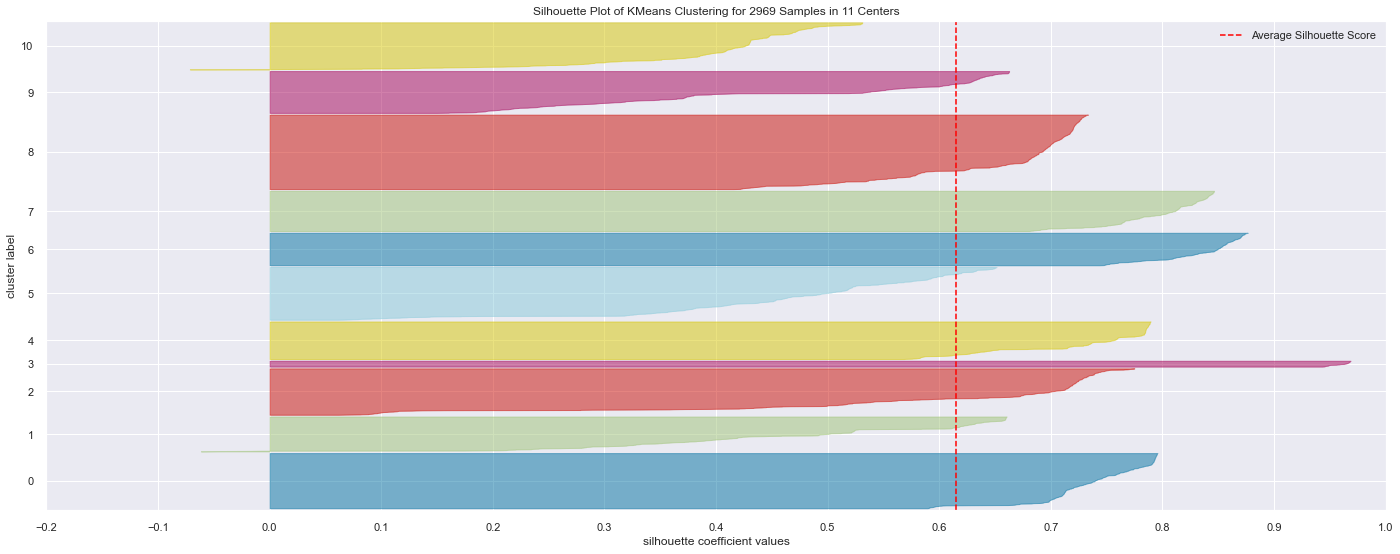

In [124]:
visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick')
visualizer.fit(X)
visualizer.finalize()

### 2d plot

In [125]:
# df9.columns

In [126]:
# previous cycle left over:
# df_viz = df9.drop(columns = 'customer_id', axis = 1)
# sns.pairplot(df_viz, hue = 'cluster')

### UMAP - t-SNE

In [127]:
# Manifold
# UMAP, t-SNE(2009) - MAnifold - Topology


In [128]:
# previou cycle left over:

# # UMAP
# reducer = umap.UMAP(n_neighbors = 9, random_state = 42)
# reducer = umap.UMAP(random_state = 42)
# embedding = reducer.fit_transform(X)

# # embedding
# df_viz['embedding_x'] = embedding[:,0]
# df_viz['embedding_y'] = embedding[:,1]

# #plotting umap
# sns.scatterplot( x = 'embedding_x', y = 'embedding_y', 
#                 hue = 'cluster', 
#                 palette = sns.color_palette('hls', n_colors = len( df_viz['cluster'].unique() ) ), data = df_viz )

## Cluster Profile


In [129]:
# df9.head()

In [130]:
# df4.gross_revenue.sum()

In [131]:

df9_aux = df4.copy()
df9_aux['cluster'] = labels

# Number of Customers
df_cluster = (df9_aux[['customer_id', 'cluster']].groupby('cluster').count().reset_index())
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Centroids - the group mean. 

# Avg Gross Revenue
df_avg_gross_revenue = (df9_aux[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index())
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, on = 'cluster', how = 'left')

# Avg recency days
df_avg_recency_days = (df9_aux[['recency_days', 'cluster']].groupby('cluster').mean().reset_index())
df_cluster = pd.merge(df_cluster, df_avg_recency_days, on = 'cluster', how = 'left')

# Avg invoices number
df_inv = (df9_aux[['n_of_dif_products', 'cluster']].groupby('cluster').mean().reset_index())
df_cluster = pd.merge(df_cluster, df_inv, on = 'cluster', how = 'left')

# Frequency
df_fre = (df9_aux[['frequency', 'cluster']].groupby('cluster').mean().reset_index())
df_cluster = pd.merge(df_cluster, df_fre, on = 'cluster', how = 'left')

# Returns
df_ret = (df9_aux[['qtt_returns', 'cluster']].groupby('cluster').mean().reset_index())
df_cluster = pd.merge(df_cluster, df_ret, on = 'cluster', how = 'left')

df_cluster


,cluster,customer_id,perc_customer,gross_revenue,recency_days,n_of_dif_products,frequency,qtt_returns
0,0,349,11.754800,1064.457135,66.687679,71.959885,0.051469,12.553009
1,1,221,7.443584,546.361810,90.221719,45.977376,0.075763,6.004525
2,2,294,9.902324,620.276939,84.183673,50.302721,0.066254,4.676871
3,3,38,1.279892,68280.195263,15.684211,1089.157895,0.156863,3320.368421
4,4,238,8.016167,1660.996303,32.764706,124.747899,0.036174,17.235294
5,5,334,11.249579,3425.631317,31.925150,202.311377,0.041720,33.062874
6,6,206,6.938363,2354.410922,43.116505,153.126214,0.037805,18.029126
7,7,255,8.588750,7760.927451,22.698039,336.725490,0.077621,81.882353
8,8,471,15.863927,335.489214,118.690021,22.048832,0.111224,5.414013
9,9,265,8.925564,1768.837434,49.275472,105.890566,0.040698,25.513208


In [132]:
df_cluster['frequency_min_max'] = mm.fit_transform(df_cluster[['frequency']])
df_cluster['recency_min_max'] = mm.fit_transform(df_cluster[['recency_days']])
df_cluster['recency_min_max'] = 1 - df_cluster['recency_min_max']
df_cluster['bubble'] = df_cluster.gross_revenue // 10
df_cluster.loc[3, 'bubble'] = 1400.0

In [133]:
df_cluster.sort_values('gross_revenue', ascending = False)
df_cluster['gross_revenue_log'] = np.log10(df_cluster['gross_revenue'])

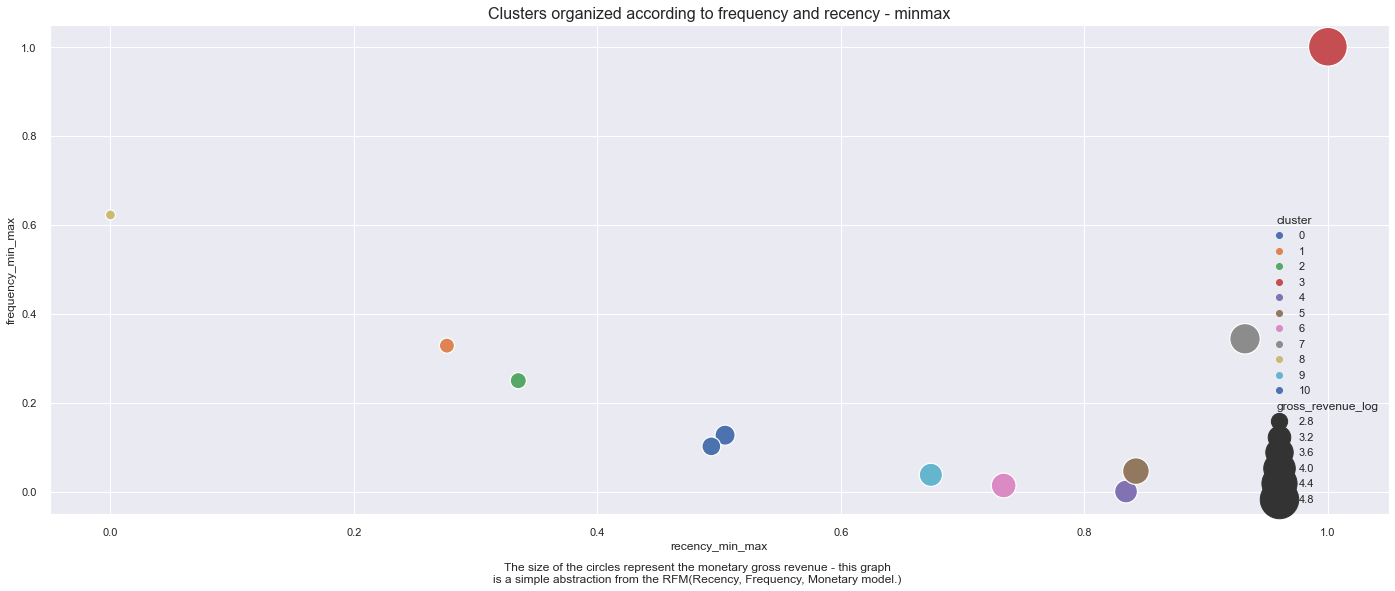

In [134]:
sns.scatterplot( x = 'recency_min_max', y = 'frequency_min_max', data = df_cluster, hue = 'cluster', palette = 'deep', size = 'gross_revenue_log', sizes = (100,1500) )
plt.title('Clusters organized according to frequency and recency - minmax', fontsize = 16)
plt.figtext(0.5,0.02, 'The size of the circles represent the monetary gross revenue - this graph\nis a simple abstraction from the RFM(Recency, Frequency, Monetary model.)', horizontalalignment =  'center');

In [135]:
cluster_names = {
    3 : 'Champion - Insiders',
    7 : 'Loyal Customers',
    5 : 'Promising recent 1',
    4 : 'Promising recent 2',
    6 : 'Promising 3',
    9 : 'Attention needed - about to sleep',
    0 : 'Attention needed 1',
    10 :'Attention needed 2',
    1 : 'Hybernating 1',
    2 : 'Hybernating 2',
    8 : 'About to lose'}
df_cluster['cluster_name'] = df_cluster['cluster'].map(cluster_names)

In [136]:
df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,n_of_dif_products,frequency,qtt_returns,frequency_min_max,recency_min_max,bubble,gross_revenue_log,cluster_name
0,0,349,11.754800,1064.457135,66.687679,71.959885,0.051469,12.553009,0.126727,0.504849,106.0,3.027128,Attention needed 1
1,1,221,7.443584,546.361810,90.221719,45.977376,0.075763,6.004525,0.328019,0.276376,54.0,2.737480,Hybernating 1
2,2,294,9.902324,620.276939,84.183673,50.302721,0.066254,4.676871,0.249230,0.334994,62.0,2.792586,Hybernating 2
3,3,38,1.279892,68280.195263,15.684211,1089.157895,0.156863,3320.368421,1.000000,1.000000,1400.0,4.834295,Champion - Insiders
4,4,238,8.016167,1660.996303,32.764706,124.747899,0.036174,17.235294,0.000000,0.834179,166.0,3.220369,Promising recent 2
5,5,334,11.249579,3425.631317,31.925150,202.311377,0.041720,33.062874,0.045948,0.842330,342.0,3.534741,Promising recent 1
6,6,206,6.938363,2354.410922,43.116505,153.126214,0.037805,18.029126,0.013509,0.733682,235.0,3.371882,Promising 3
7,7,255,8.588750,7760.927451,22.698039,336.725490,0.077621,81.882353,0.343421,0.931908,776.0,3.889914,Loyal Customers
8,8,471,15.863927,335.489214,118.690021,22.048832,0.111224,5.414013,0.621847,0.000000,33.0,2.525679,About to lose
9,9,265,8.925564,1768.837434,49.275472,105.890566,0.040698,25.513208,0.037483,0.673890,176.0,3.247688,Attention needed - about to sleep


### Cluster Synthesis

In [137]:
# df_cluster.columns

In [138]:
df_cluster.columns = ['cluster', 'number_of_customers', 'perc_customer', 'gross_revenue',
       'recency_days', 'n_of_dif_products', 'frequency', 'qtt_returns',
       'frequency_min_max', 'recency_min_max', 'aux_bubble', 'gross_revenue_log','cluster_name'
       ]

In [139]:
df_cluster_rep = df_cluster.sort_values('cluster').reset_index(drop = True)

for i in range(len(np.unique(df_cluster_rep['cluster']))):
    print('Cluster {}: "{}"'.format(df_cluster_rep.loc[i, 'cluster'], df_cluster_rep.loc[i, 'cluster_name']))
    print(' - Number of customers {} ({:,.2f} % of total)'.format(df_cluster_rep.loc[i, 'number_of_customers'], df_cluster_rep.loc[i, 'perc_customer']) )
    print(' - Average amount spent in total ${:,.2f} '.format(df_cluster_rep.loc[i, 'gross_revenue']) )
    print(' - Average Recency (days) {:,.2f} \n'.format(df_cluster_rep.loc[i, 'recency_days']) )

Cluster 0: "Attention needed 1"
 - Number of customers 349 (11.75 % of total)
 - Average amount spent in total $1,064.46 
 - Average Recency (days) 66.69 

Cluster 1: "Hybernating 1"
 - Number of customers 221 (7.44 % of total)
 - Average amount spent in total $546.36 
 - Average Recency (days) 90.22 

Cluster 2: "Hybernating 2"
 - Number of customers 294 (9.90 % of total)
 - Average amount spent in total $620.28 
 - Average Recency (days) 84.18 

Cluster 3: "Champion - Insiders"
 - Number of customers 38 (1.28 % of total)
 - Average amount spent in total $68,280.20 
 - Average Recency (days) 15.68 

Cluster 4: "Promising recent 2"
 - Number of customers 238 (8.02 % of total)
 - Average amount spent in total $1,661.00 
 - Average Recency (days) 32.76 

Cluster 5: "Promising recent 1"
 - Number of customers 334 (11.25 % of total)
 - Average amount spent in total $3,425.63 
 - Average Recency (days) 31.93 

Cluster 6: "Promising 3"
 - Number of customers 206 (6.94 % of total)
 - Average 

## Hypothesis Testing

### MindMap

In [140]:
df10 = df9_aux.copy()
df10['cluster_name'] = df10['cluster'].map(cluster_names)
# df10.sample(8)

- Modeling the phenomena.
- Understanding entities (customer, location, family, income)
- Entity properties (eg. customer: income, education, age group, etc)


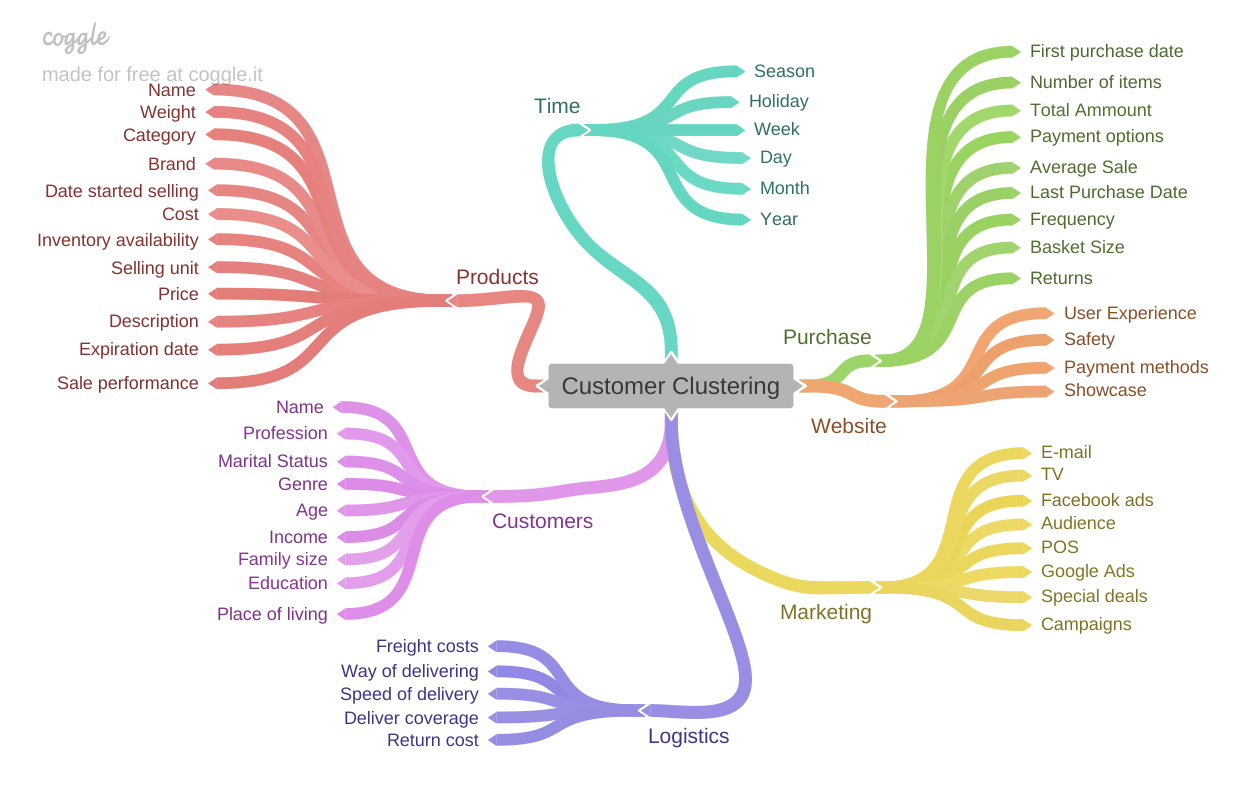

In [141]:
from IPython.core.display import Image
Image(home_path + 'mindmap.png')

### Hypothesis Purchases: 

#### Insiders cluster customers represent more than 20% of total revenue.

In [142]:
insiders = df10.loc[df10['cluster'] == 3, 'gross_revenue'].sum()
# df_sales_not_insiders = df10.loc[df10['cluster'] == 3, 'item_ammt'].median()
total =df10.loc[:, 'gross_revenue'].sum()
print ( 'insiders / total: {:.2f}%'.format(insiders / total * 100) )

insiders / total: 31.79%


TRUE. Insiders represent more than 30% of gross revenue

####  Customers in the Insiders cluster have a number of returns below the average of the total customer base.


In [143]:
# avg returns inside
df_avg_return_insiders = df10.loc[df10['cluster'] == 3, 'qtt_returns'].mean()

# avg return total
df_avg_return_all = df10['qtt_returns'].mean()

#
print( 'Avg Return Insiders: {} vs Avg Return All:{}'.format( np.round( df_avg_return_insiders, 0 ), 
                                                              np.round( df_avg_return_all, 0 ) ) )

Avg Return Insiders: 3320.0 vs Avg Return All:62.0


FALSE. Average return for insiders are higher.

#### Cheaper products are more transactioned than expensive ones.

In [144]:


bins = list(range(0,1100,100))
df2['binned_price'] = pd.cut(df2['unit_price'], bins=bins)

aux2 = df2[['unit_price','binned_price']].groupby('binned_price').count().reset_index()
# plt.subplot(1,3,2)
# sns.barplot(x = 'binned_price', y = 'unit_price', data = aux2)
aux2.columns = ['binned_price', 'transactions_ammt']
aux2

,binned_price,transactions_ammt
0,"(0, 100]",535996
1,"(100, 200]",123
2,"(200, 300]",11
3,"(300, 400]",2
4,"(400, 500]",5
5,"(500, 600]",1
6,"(600, 700]",3
7,"(700, 800]",0
8,"(800, 900]",0
9,"(900, 1000]",1


TRUE. Most of transactions comprehend products up to 100 euros.

#### Customers in the Insiders program account for more than 30% of company gross revenue.

In [145]:
# defining dataset with cluster names
# names = {"4" : "Insiders", "1" : "Potential Loyalists", "0" : "Loyal Customers", "2" : "Promissing 1", "8" : "Need Attention 1", "6" : "Promising 2", "7" : "Need Attention 2", "5" : "Hibernating 1", "10" : "Churn 1", "3" : "Price Sensitive", "9" : "Churn 2", "11" : "Hibernating 2", "-1" : 'Noise' }


# summing revenue by cluster
df_agg = df10[['cluster', 'gross_revenue']].copy()
df_agg = df_agg.groupby('cluster').sum().reset_index()
df_agg['cluster_name'] = df_agg['cluster'].map(cluster_names)
# df_agg

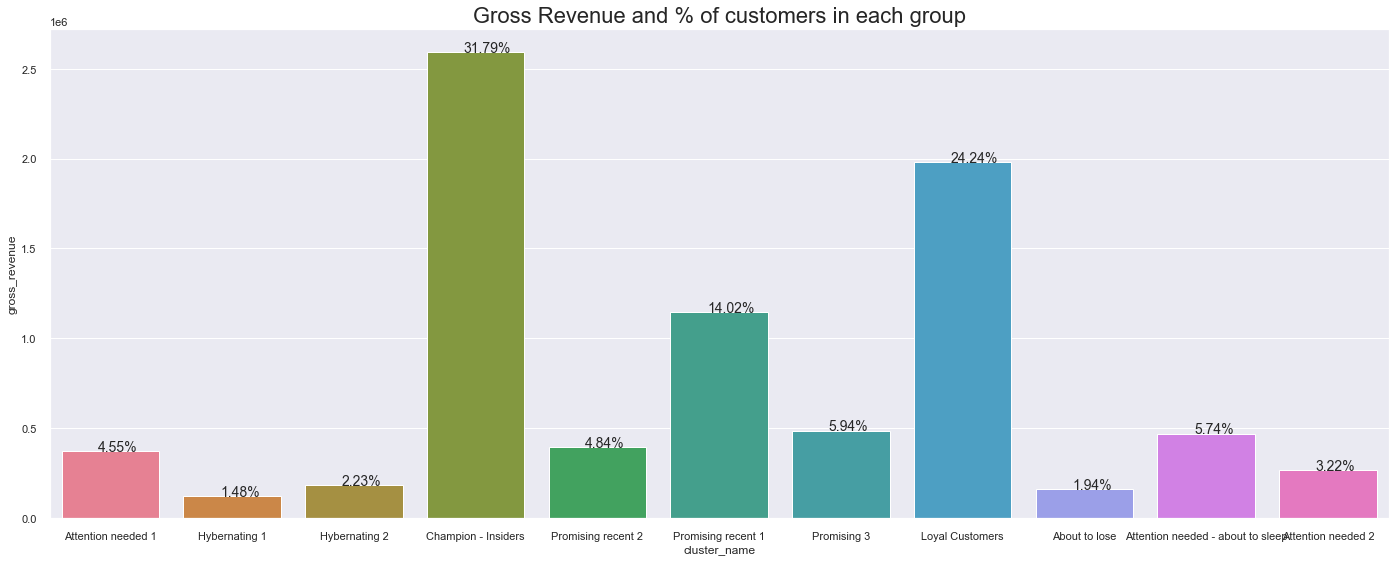

In [146]:
# ploting the results
bar = sns.barplot(data = df_agg, x = 'cluster_name', y = 'gross_revenue', palette = 'husl'); 
plt.title("Gross Revenue and % of customers in each group", fontsize = 22);
#plt.figtext(0.5,0, 'he')
bar_order = list(df_agg['cluster_name'].unique())
spots = zip(bar.patches, bar_order)
for spot in spots:
    total = df_agg['gross_revenue'].sum()
    class_total = df_agg[df_agg['cluster_name'] == spot[1]]['gross_revenue']
    
    percent = float(class_total/total*100)

    height = spot[0].get_height()
    bar.text(spot[0].get_x()+0.3, height+5, '{:.2f}%'.format(percent), fontsize = 14 )


TRUE. They account for almost 31,79%.

### Business questions

#### Who are the people elegible for the Insiders program?

In [147]:
insiders_id = list(df10.loc[df10['cluster'] == 3, 'customer_id'])
print(insiders_id)

[15311, 16029, 17511, 13408, 13694, 12748, 14911, 17841, 13777, 17381, 15061, 14156, 13798, 14680, 16013, 17949, 15769, 13081, 13089, 16422, 17450, 15838, 18102, 17857, 14298, 17404, 16684, 12931, 14646, 13027, 12415, 15749, 14088, 13098, 16333, 12901, 16446, 14096]


#### How many people are part of this group?

In [148]:
print(df10.loc[df10['cluster'] == 3, 'customer_id'].size)

38


#### What are the main characteristics of the insiders group?

In [149]:
print(f"Total Number of Insiders: {len(df10.loc[df10['cluster'] == 3, 'customer_id'])} out of {len(df10['customer_id'])}")
print(f"Average Gross Revenue Insiders: {df10.loc[df10['cluster'] == 3, 'gross_revenue'].mean():.2f}, Overall: {df10['gross_revenue'].mean():.2f}")
print(f"Median Gross Revenue Insiders: {df10.loc[df10['cluster'] == 3, 'gross_revenue'].median():.2f}, Overall: {df10['gross_revenue'].median():.2f}")
print(f"Average Recency Insiders: {df10.loc[df10['cluster'] == 3, 'recency_days'].mean():.2f}, Overall: {df10['recency_days'].mean():.2f}")
print(f"Average Frequency Insiders: {df10.loc[df10['cluster'] == 3, 'frequency'].mean():.2f}, Overall: {df10['frequency'].mean():.2f}")
print(f"Average different products purchased Insiders: {df10.loc[df10['cluster'] == 3, 'avg_basket_size'].mean():.2f}, Overall: {df10['avg_basket_size'].mean():.2f}")


Total Number of Insiders: 38 out of 2969
Average Gross Revenue Insiders: 68280.20, Overall: 2749.32
Median Gross Revenue Insiders: 47513.06, Overall: 1086.92
Average Recency Insiders: 15.68, Overall: 64.29
Average Frequency Insiders: 0.16, Overall: 0.06
Average different products purchased Insiders: 2289.02, Overall: 249.81


In [150]:
# Break here

# Deploy to production

In [151]:

# from sqlalchemy import create_engine

# host = 
# port = 5432
# database ='postgres'
# user = 'postgres'
# pwd = 
# endpoint = f'postgresql://{user}:{pwd}@{host}:{port}'

# conn = create_engine(endpoint)



In [152]:
# query_table_df10_creation = '''
#     CREATE TABLE df_10_insiders (
#         customer_id            INTEGER,
#         gross_revenue          REAL,
#         recency_days           INTEGER,
#         invoice_ammt           INTEGER,
#         item_ammt              INTEGER,
#         n_of_dif_products      INTEGER,
#         avg_ticket             REAL,
#         avg_recency_days       REAL,
#         frequency              REAL,
#         qtt_returns            INTEGER,
#         avg_basket_size        REAL,
#         avg_unique_basket_size REAL,
#         cluster                INTEGER,
#         cluster_name           TEXT
#     )
#     '''

# query_table_df_cluster_creation = '''
#     CREATE TABLE df_cluster (
#         cluster                INTEGER,
#         number_of_customers    INTEGER,
#         perc_customer          REAL,
#         gross_revenue          REAL,
#         recency_days           REAL,
#         n_of_dif_products      REAL,
#         frequency              REAL,
#         qtt_returns            REAL,
#         frequency_min_max      REAL,
#         recency_min_max        REAL,
#         aux_bubble             REAL,
#         gross_revenue_log      REAL,
#         cluster_name           TEXT
#     )
#     '''
        

# conn.execute(query_table_df10_creation)
# conn.execute(query_table_df_cluster_creation)


In [153]:
# df10.to_sql( 'df_10_insiders', con=conn, if_exists='append', index=False )

# df_cluster.to_sql( 'df_cluster', con=conn, if_exists='append', index=False )

In [154]:
# conn.close()